**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
SnowballStemmer + TFIDF + DBSCAN

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt

SKLEARN_VERSION

'1.0.2'

In [3]:
# from nltk.stem.snowball import SnowballStemmer
# from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/text/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [5]:
data.sample(2)

,text,tag
1441,"Арестованный за взятку экс-губернатор Сахалина Александр Хорошавин обжаловал конфискацию своего имущества в Конституционном суде на 1,1 млрд рублей.\n\nГазета ""Коммерсантъ"" пишет, что Хорошавины п...",politics
1642,Сильное извержение вулкана Безымянный может произойти в ближайшее время на Камчатке. Об этом заявила руководитель Камчатской группы реагирования на вулканические извержения (KVERT) Института вулка...,science


## токенизация и очистка

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

##  Vectorizer

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer_stemmer(s,stemmer=stemmer,stopwords=stopwords): 
    for w in s.split(' '):
        o = stemmer.stem(w).replace('^','')
        if len(o)<2: continue
        if o in stopwords: continue
        yield o        

In [9]:
%%time

X = TfidfVectorizer(
        use_idf=True,
        norm='l2',
        tokenizer=tokenizer_stemmer,
        token_pattern=None,
    ).fit_transform( data['ctext'] )

CPU times: user 1min 18s, sys: 98.1 ms, total: 1min 18s
Wall time: 1min 21s


In [10]:
X.shape

(3196, 36354)

## кластеризируем

In [48]:
%%time 

data['cluster'] = DBSCAN(eps=1.05,min_samples=11).fit(X).labels_
data['cluster'].drop_duplicates().count()

CPU times: user 972 ms, sys: 136 ms, total: 1.11 s
Wall time: 1.14 s


53

## тестируем

In [49]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2372,reclama social tech auto incident realty sport science politics health culture woman economics
1,0,32,politics
2,1,17,politics
3,2,21,politics
4,3,19,politics
5,4,37,politics
6,5,28,politics
7,6,11,politics
8,7,14,politics
9,8,43,politics


<AxesSubplot:xlabel='cluster'>

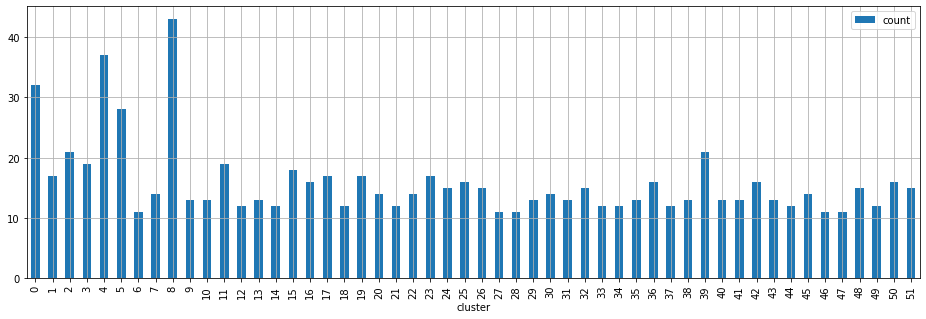

In [50]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [51]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [52]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 7, элементов: 14, метки: "politics" ]

Президент Венесуэлы Николас Мадуро объявил, что в рамках денежной реформы по выводу из обращения банкнот достоинством 100 боливаров на трое суток закрывается граница страны с соседней Колумбией.  Мадуро обвинил мафиозные кланы в том, что они организовали на границе с Колумбией бизнес по обмену валют ...


Венесуэла закрыла границу с Колумбией на 72 часа для борьбы с мафией, которая занималась экономическими преступлениями. Об этом сообщает РИА "Новости".  Отмечается, что президент Венесуэлы Николас Мадуро распорядился закрыть границу, так как озабочен происходящим на границе.  По некоторым данным, за ...


Венесуэла на 72 часа закрыла границу с Колумбией  МЕХИКО, 13 дек – РИА Новости. Президент Венесуэлы Николас Мадуро распорядился закрыть границу с Колумбией на 72 часа для борьбы с финансовой мафией.  В сообщении правительства Венесуэлы отмечается озабоченность происходящим на границе. "Мы выражаем с ...


= = = = = = = = = = = = = = = 